<a href="https://colab.research.google.com/github/victor-roris/ML-learning/blob/master/ComputerVision/DeepLearning_ComputerVision_EfficientDet_Custom_DataSpartan_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientDet -  Custom DataSpartan dataset

Notebook to train a EfficientDet model with custom dataset generated in the AIDocs project of DataSpartan. This dataset is about document segmentation and it is accesible from my profesional drive account (this is private and not public available).

This notebook is an adaptation from: [tutorial notebook](https://colab.research.google.com/drive/1ZmbeTro4SqT7h_TfW63MLdqbrCUk_1br#scrollTo=KwDS9qqBbMQa)

EfficientDet : [link](https://models.roboflow.com/object-detection/efficientdet), [link](https://github.com/roboflow-ai/Monk_Object_Detection), [link](https://arxiv.org/abs/1911.09070)

In [1]:
from IPython.display import clear_output

## Install

We clone the fork of `EfficientDet` from `roboflow-ai` 

In [2]:
#our fork of the Tessellate-Imaging image detection library
#!rm -rf Monk_Object_Detection
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git

Cloning into 'Monk_Object_Detection'...
remote: Enumerating objects: 3747, done.
remote: Total 3747 (delta 0), reused 0 (delta 0), pack-reused 3747
Receiving objects: 100% (3747/3747), 132.20 MiB | 10.76 MiB/s, done.
Resolving deltas: 100% (800/800), done.
Checking out files: 100% (4032/4032), done.


Install requirements

In [3]:
!ls Monk_Object_Detection/3_mxrcnn/installation

requirements_colab.txt	   requirements_cuda10.1.txt  requirements_cuda9.2.txt
requirements_cuda10.0.txt  requirements_cuda9.0.txt


In [4]:
# For colab use the command below
# Set up library requirments
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install
clear_output()

In [5]:
#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX
clear_output()

## Imports

In [6]:
# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

## Dataset

### Download

This dataset is accesible from my profesional driver account (this is not public available)

This database is a zip file with a folder with images and label segmentations.

In this code we download and unzip this file. Then, we split the annotation in train and validation folders. 

Connect with my drive (@dataspartan)


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
cp /content/drive/My\ Drive/DATASPARTAN/PROYECTOS/AI-DOCUMENTS/SEGMENTATION/export..segmentation..2020.08.07.tar.gz  /content/.

In [10]:
# Export dataset filepath
dataset_folderpath = "/content/dataset/"

In [11]:
import os
if os.path.isdir(dataset_folderpath):
  !rm -R {dataset_folderpath}

In [12]:
from pathlib import Path
def mkdir(sfolderpath):
  folderpath = Path(sfolderpath)
  folderpath.mkdir(parents=True, exist_ok=True)

mkdir(dataset_folderpath)

In [13]:
!mkdir dataset
!tar -zxvf export..segmentation..2020.08.07.tar.gz -C {dataset_folderpath}
clear_output()
!ls {dataset_folderpath}

export_coco.json  segmentation	  yolo_data.yaml
image		  sub_annotation  yolo_labels


### Split the coco dataset

The coco dataset uses a integer identifier generated using uuid function (it generates a 8 bit integer). A so long integer generates an error in detectron2. I modify the used identifier to this notebook.

In [14]:
images_folderpath = os.path.join(dataset_folderpath, 'image')
coco_filepath = os.path.join(dataset_folderpath, 'export_coco.json')
with open(coco_filepath) as f:
    data = json.load(f)
print("List of sections in the original coco file: ", list(data.keys()))

List of sections in the original coco file:  ['annotations', 'categories', 'images', 'licenses']


Copy the coco file to the model expected folder

In [29]:
!mkdir ./dataset/annotations
!cp ./dataset/export_coco.json ./dataset/annotations/instances_image.json

# Training

In this section we set up the efficientDet-d0 model from backbone and train to our custom case

In [1]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/")

In [2]:
from train_detector import Detector

In [3]:
gtf = Detector()

In [4]:
#directs the model towards file structure
root_dir = "./"
coco_dir = "dataset"
img_dir = ""
set_dir = "image"

In [5]:
#smells like some free compute from Colab, nice
gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=8, image_size=512, use_gpu=True)

loading annotations into memory...
Done (t=1.07s)
creating index...
index created!


In [6]:
gtf.Model();

Loaded pretrained weights for efficientnet-b0


In [7]:
gtf.Set_Hyperparams(lr=0.0001, val_interval=1, es_min_delta=0.0, es_patience=0)

In [9]:
%%time
gtf.Train(num_epochs=10, model_output_dir="trained/");

Monk_Object_Detection/4_efficientdet/lib/src/model.py:251: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if len(inputs) == 2:
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:84: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  image_shape = np.array(image_shape)
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:96: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this fu

CPU times: user 32min 5s, sys: 10min 56s, total: 43min 1s
Wall time: 44min 27s


## Inference

In [25]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/")

In [26]:
from infer_detector import Infer

In [33]:
gtf = Infer()
gtf.Model(model_dir="./trained")

In [28]:
#extract class list from our annotations
import json
with open('./dataset/export_coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

In [29]:
class_list

['text', 'title', 'list', 'table', 'figure']

In [103]:
test_images = [f for f in os.listdir('./dataset/image') if f.endswith('.png')]
import random
img_path = "./dataset/image/" + random.choice(test_images)
img_path

'./dataset/image/econreports..001477.png'

In [104]:
%%time
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2)

Done. (0.066s)
CPU times: user 122 ms, sys: 7.86 ms, total: 130 ms
Wall time: 128 ms


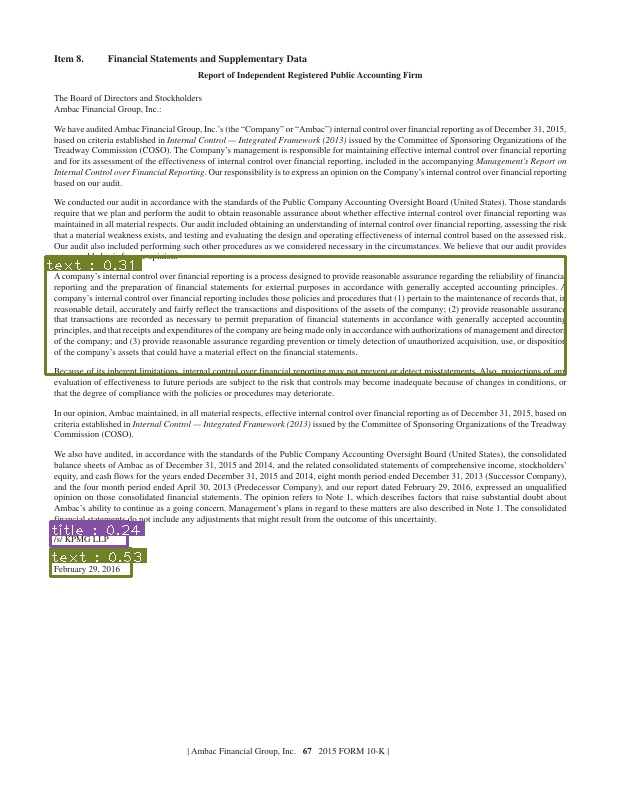

In [105]:
from IPython.display import Image
Image(filename='output.jpg') 

In [106]:
# Confidence 
scores.cpu().numpy()

array([0.53151906, 0.31475455, 0.23824397, 0.1956349 , 0.15798226,
       0.13940042, 0.10992267, 0.09644748, 0.08994644, 0.08863956,
       0.08689678, 0.08576073, 0.08575157, 0.08245073, 0.0790429 ,
       0.07711826, 0.07002028, 0.06792983, 0.06100276, 0.05949994,
       0.05819097, 0.05792452, 0.05772731, 0.05662964, 0.05478348,
       0.05441053, 0.05389395, 0.05329576, 0.05203163, 0.05132066],
      dtype=float32)

In [107]:
# Labels
labels

tensor([0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 0, 1], device='cuda:0')

In [108]:
# Categories
cats = [class_list[label] for label in labels.cpu().numpy()]
cats

['text',
 'text',
 'title',
 'text',
 'title',
 'text',
 'title',
 'title',
 'title',
 'text',
 'title',
 'text',
 'text',
 'text',
 'text',
 'title',
 'text',
 'text',
 'title',
 'title',
 'title',
 'title',
 'title',
 'text',
 'title',
 'title',
 'text',
 'text',
 'text',
 'title']

In [109]:
# Boxes
boxes.cpu().numpy()

array([[ 50.73654 , 548.55176 , 131.59138 , 576.2951  ],
       [ 45.909187, 256.90997 , 565.8163  , 374.63098 ],
       [ 50.78753 , 521.4997  , 127.78529 , 546.6776  ],
       [ 37.28881 , 123.64959 , 580.26025 , 363.77704 ],
       [ 47.082314, 533.2549  , 134.18996 , 565.2631  ],
       [ 55.04447 , 435.20505 , 532.58936 , 544.12933 ],
       [ 52.43831 ,  69.849785, 530.1767  , 220.59404 ],
       [305.89343 , 358.5742  , 559.03174 , 422.67563 ],
       [393.03262 , 401.1307  , 569.59216 , 437.44916 ],
       [ 56.25543 , 569.5144  , 128.46289 , 594.409   ],
       [ 53.828823, 502.2606  , 121.477974, 534.9301  ],
       [ 56.46394 , 580.67114 , 124.89449 , 608.31903 ],
       [471.44678 , 403.10312 , 565.92883 , 433.4107  ],
       [ 52.847687, 408.7395  , 151.13045 , 442.05307 ],
       [422.49667 , 125.78121 , 555.1358  , 180.38875 ],
       [ 46.312405,  53.51542 , 291.41284 , 120.22394 ],
       [ 54.223976, 540.84546 , 133.26349 , 597.8471  ],
       [ 35.317368, 444.05032 ,

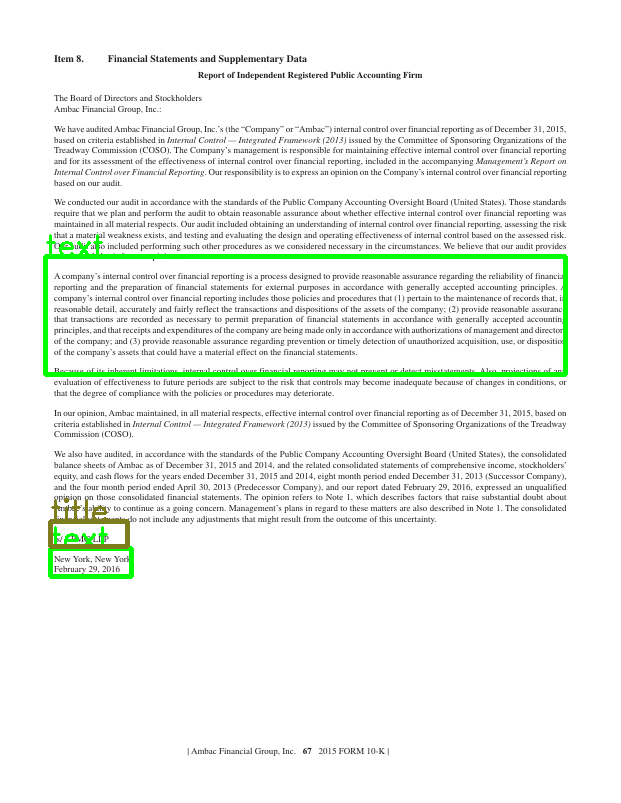

In [113]:
import numpy as np
import cv2

img = cv2.imread(img_path)
threshold = 0.2

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
lineType = 2
colors = [(0,255,0),(30,125,125),(40,40,40),(80,158,80),(62,139,70),(33,209,127)]
for idx,score in enumerate(scores):
  if score <= threshold:
    continue
  cat = cats[idx]
  box = boxes[idx]
  cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),colors[labels[idx]],3)

  cv2.putText(img,cat, (box[0],box[1]), font, fontScale, colors[labels[idx]], lineType)

from google.colab.patches import cv2_imshow
cv2_imshow(img)

## Measuring Performance

We use the library `mAP` ([github](https://github.com/Cartucho/mAP)) to measure the performance. We use the same strategy that this [notebook](https://colab.research.google.com/drive/1pLvZpz0_Ob0yOQ7hxPhVRT04Cb3FGARb#scrollTo=-78frQ4211c8)

In [ ]:
# It fails with images without labels (we create a empty file)
for f in os.listdir('./dataset/image/'):
  if not os.path.isfile("./dataset/yolo_labels/" + f[:-4] + ".txt"):
    f = open("./dataset/yolo_labels/" + f[:-4] + ".txt", "w")
    f.close()

In [114]:
%cd /content/
!git clone https://github.com/Cartucho/mAP

/content
Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 7.38 MiB/s, done.
Resolving deltas: 100% (321/321), done.


In [118]:
f = open("./mAP/scripts/extra/class_list.txt", "w")
for cls in class_list:
  f.write(cls+"\n")
f.close()

f = open("./mAP/input/labels.labels", "w")
for cls in class_list:
  f.write(cls+"\n")
f.close()

In [137]:
%rm -rf mAP/input/ground-truth/
%mkdir mAP/input/ground-truth/
%mkdir mAP/input/images
%mkdir mAP/input/images-optional/

%cp ./dataset/yolo_labels/*txt mAP/input/ground-truth/
%cp ./dataset/image/* mAP/input/images-optional/
%cp ./dataset/image/* mAP/input/images/

%rm -rf mAP/input/detection-results/
%mkdir mAP/input/detection-results/

mkdir: cannot create directory ‘mAP/input/images’: File exists
mkdir: cannot create directory ‘mAP/input/images-optional/’: File exists


In [ ]:
for f in os.listdir('./dataset/image/'):
  duration, scores, labels, boxes = gtf.Predict('./dataset/image/'+f, class_list, vis_threshold=0.2);
  scores = scores.tolist()
  boxes = boxes.tolist()
  labels = labels.tolist()
  with open('mAP/input/detection-results/' + f[:-4] + '.txt', 'w') as out_file:
    #write detection result
    for i in range(len(scores)):
      #print(scores)
      line = class_list[labels[i]] + ' ' + str(scores[i]) + ' ' + str(' '.join([str(j) for j in boxes[i]]))
      out_file.write(line)
      if i < len(scores) - 1:
        out_file.write('\n')

Done. (0.069s)
Done. (0.064s)
Done. (0.063s)
Done. (0.063s)
Done. (0.064s)
Done. (0.064s)
Done. (0.064s)
Done. (0.064s)
Done. (0.063s)
Done. (0.063s)
Done. (0.064s)
Done. (0.062s)
Done. (0.062s)
Done. (0.062s)
Done. (0.063s)
Done. (0.065s)
Done. (0.063s)
Done. (0.063s)
Done. (0.077s)
Done. (0.063s)
Done. (0.062s)
Done. (0.062s)
Done. (0.062s)
Done. (0.062s)
Done. (0.062s)
Done. (0.062s)
Done. (0.063s)
Done. (0.062s)
Done. (0.062s)
Done. (0.062s)
Done. (0.063s)
Done. (0.063s)
Done. (0.063s)
Done. (0.063s)
Done. (0.063s)
Done. (0.063s)
Done. (0.062s)
Done. (0.063s)
Done. (0.062s)
Done. (0.063s)
Done. (0.063s)
Done. (0.066s)
Done. (0.063s)
Done. (0.063s)
Done. (0.063s)
Done. (0.063s)
Done. (0.061s)
Done. (0.061s)
Done. (0.069s)
Done. (0.061s)
Done. (0.063s)
Done. (0.061s)
Done. (0.060s)
Done. (0.060s)
Done. (0.060s)
Done. (0.060s)
Done. (0.060s)
Done. (0.060s)
Done. (0.060s)
Done. (0.060s)
Done. (0.061s)
Done. (0.061s)
Done. (0.060s)
Done. (0.059s)
Done. (0.059s)
Done. (0.060s)
Done. (0.0

In [ ]:
#evaluation results for EfficientDet
!python mAP/main.py -na

## Export Trained Weights

In [42]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
%mkdir trained_export
%cp ./trained/signatrix_efficientdet_coco.onnx ./trained_export/signatrix_efficientdet_coco_$(date +%F-%H:%M).onnx
%cp ./trained/signatrix_efficientdet_coco.pth ./trained_export/signatrix_efficientdet_coco_$(date +%F-%H:%M).pth
%mv ./trained_export/* /content/drive/My\ Drive/

## Reloading Trained Weights after Export

Imagine you have exported your trained model and would like to reaccess it later. This portion of the notebook picks up the trained model and starts at inference

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Clone the EfficientDet

In [45]:
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git

fatal: destination path 'Monk_Object_Detection' already exists and is not an empty directory.


Install libraries

In [ ]:
# For colab use the command below
# Set up library requirments
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX
clear_output()

Trained weights

In [47]:
#recover trained weights
!mkdir './pretrained'
#note these are old weights that I didn't train for too long
!cp '/content/drive/My Drive/signatrix_efficientdet_coco_2020-04-10-15:18.onnx' './pretrained/signatrix_efficientdet_coco.onnx'
!cp '/content/drive/My Drive/signatrix_efficientdet_coco_2020-04-10-15:18.pth' './pretrained/signatrix_efficientdet_coco.pth'

cp: cannot stat '/content/drive/My Drive/signatrix_efficientdet_coco_2020-04-10-15:18.onnx': No such file or directory
cp: cannot stat '/content/drive/My Drive/signatrix_efficientdet_coco_2020-04-10-15:18.pth': No such file or directory


List of clases

In [49]:
class_list = ['text', 'title', 'list', 'table', 'figure']

Image to test

In [52]:
!curl "https://image.slidesharecdn.com/pdfessentialforbuisnessdocuments-100430022547-phpapp02/95/pdf-essential-for-business-documents-1-728.jpg?cb=1272594385" --output "test.jpg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  187k  100  187k    0     0   661k      0 --:--:-- --:--:-- --:--:--  661k


In [53]:
img_path = "./test.jpg"

Prediction

In [48]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/")

In [61]:
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2)

Done. (0.063s)


Visualize results

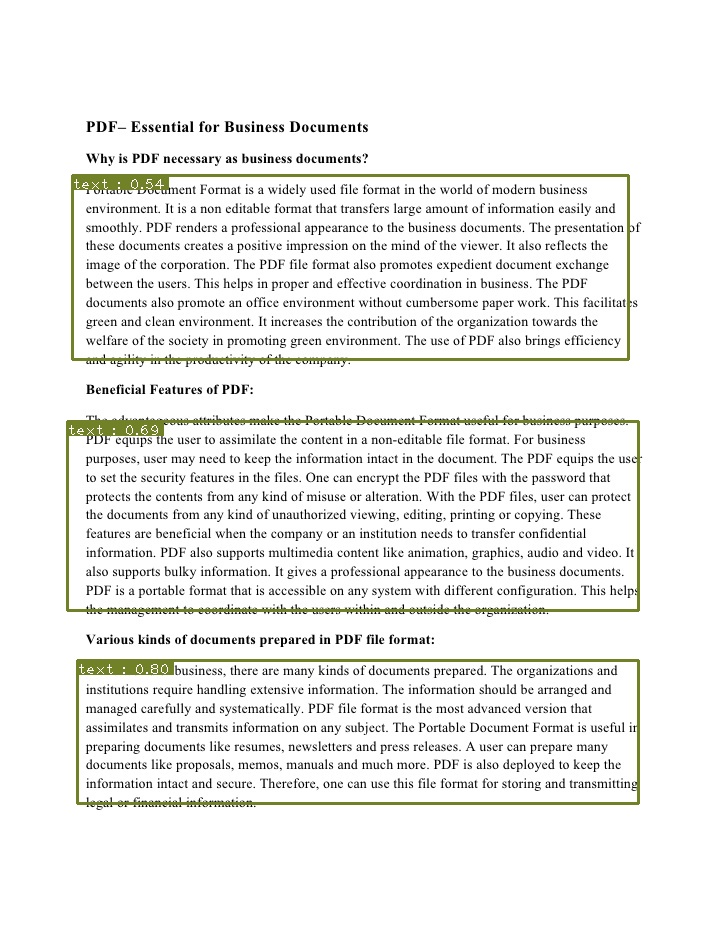

In [62]:
# Visualize the exported image prediction
from IPython.display import Image
Image(filename='output.jpg') 